# Training loop implementation

Notebook for development of training loop

In [1]:
import time
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dqn_implementation.model import DQN
from dqn_implementation.data.utilities import rgb2grayscale
from skimage.transform import resize

In [ ]:
# TODO Hyperparameter search and training

In [28]:
env = gym.make('Breakout-v0')

batch_size = 32
epochs = 200
action_count = env.action_space.n

# +1s are added because of the way states are acquired (second state is new state for first state)
stacked_frames = 4
# replay_memory_size = 1_000_000
replay_memory_size = 10_000 + 1
# replay_start_size = 50_000
replay_start_size = 500 + 1 
action_repeat = 4
update_frequency = 4
noop_max = 30
scaling_factor = 0.99
# network_update_frequency = 10_000
network_update_frequency = 100
# end_eps_frame = 1_000_000
end_eps_frame = 10_000
eps_beg = 1.0
eps_end = 0.1
eps_step = (eps_beg - eps_end) / end_eps_frame

episodes_end = np.zeros((replay_memory_size), dtype=bool)

device = torch.device('cuda')

In [29]:
dqn_current = DQN(action_count).to(device)
dqn_new = DQN(action_count).to(device)
dqn_new.load_state_dict(dqn_current.state_dict())

# optimizer = optim.RMSprop(dqn_new.parameters(), lr=25e-5, momentum=0.95, eps=0.01, alpha=0.95)
optimizer = optim.RMSprop(dqn_new.parameters(), lr=25e-7, momentum=0.95, eps=0.01, alpha=0.95)
# optimizer = optim.SGD(dqn_new.parameters(), lr=0.00001)

In [30]:
# These four together form the memory consisting of experiences e = (s,a,r,s')
states = np.zeros(shape=(replay_memory_size, stacked_frames, 84, 84))
actions = np.zeros(shape=(replay_memory_size))
rewards = np.zeros(shape=(replay_memory_size))

total_frames = 0
memory_frames = 0


121698


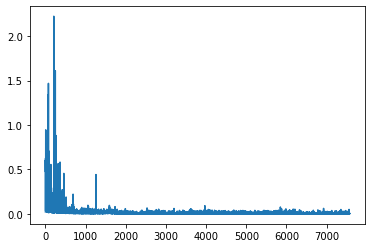

In [31]:
reward_sum = np.zeros(shape=(epochs))
losses = []

for epoch in tqdm(range(epochs)):
    env.reset()
    
    last_frames = np.zeros(shape=(stacked_frames, 84, 84))
    last_frame = np.zeros(shape=(210, 160, 3))

    previous_action = None

    noops = 0    
    episode_frames = 0
    
    while(True):
        env.render()
        # Interact with environment
        action = None
        epsilon = max(eps_beg - (total_frames * eps_step), eps_end)

        if episode_frames % action_repeat == 0:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                inp_torch = torch.from_numpy(last_frames[None, :]).float().to(device)
                action_torch = dqn_current(inp_torch).argmax(axis=1)[0]
                action = action_torch.cpu().detach().numpy()
        else:
            action = previous_action

        observation, reward, done, info = env.step(action)
        
        # Clip reward
        reward = min(reward, 1.0)
        
        # Saving data for memory replay
        if episode_frames > (stacked_frames - 1):
            states[memory_frames % replay_memory_size] = last_frames
            actions[memory_frames % replay_memory_size] = action
            rewards[memory_frames % replay_memory_size] = reward
            
            # If this is the last point of episode, mark it in episodes_end array
            if done or (noops >= 30):
                episodes_end[memory_frames % replay_memory_size] = True
            else:
                episodes_end[memory_frames % replay_memory_size] = False
            
            memory_frames += 1

        previous_action = action

        # Max over last two frames, conversion RGB -> grayscale, rescale
        frame = np.where(last_frame > observation, last_frame, observation)
        frame = rgb2grayscale(frame)
        frame = resize(frame, (84, 84))

        # Stacking last four frames and assigning last frame (observation)
        last_frames = np.concatenate((last_frames[1:], frame[None, :]))
        last_frame = observation

        # Training
        if memory_frames >= replay_start_size:
            if total_frames % (update_frequency * action_repeat) == 0:
                # -1 because of shifted states
                experience_count = min(memory_frames, replay_memory_size - 1)
                episodes_end_indices = np.array(episodes_end).nonzero()[0]
                batch_indices = np.random.choice(range(experience_count-1), batch_size, False)
                
                s = torch.from_numpy(states[batch_indices]).float().to(device) 
                a = torch.from_numpy(actions[batch_indices]).float().to(device) 
                r = torch.from_numpy(rewards[batch_indices]).float().to(device) 
                sn = torch.from_numpy(states[batch_indices+1]).float().to(device) 
                
                # Mask out rewards of new states when new state isn't terminal
                episodes_end_mask = torch.from_numpy((batch_indices[:, None] == episodes_end_indices[None, :]).any(axis=1)).to(device)
                
                # Select only outputs corresponding to selected actions
                output_current = dqn_current(sn)[range(batch_size), a.to(torch.long)]
                output_new = dqn_new(s)[range(batch_size), a.to(torch.long)]
                
                # IF current state is the last state of episode, don't compute value of new state
                output_current = torch.where(episodes_end_mask, torch.zeros(batch_size, device=device) , output_current)
                
                target = r + (scaling_factor * output_current)

                optimizer.zero_grad()

                loss = F.mse_loss(output_new, target)
                losses.append(loss.detach())
                loss.backward()

                optimizer.step()

            if total_frames % network_update_frequency == 0:
                dqn_current.load_state_dict(dqn_new.state_dict())

        if action == 0 and episode_frames < noop_max:
            noops += 1
        else:
            noops = 0
            
        reward_sum[epoch] += reward

        episode_frames += 1
        total_frames += 1
        
#         time.sleep(0.01)
            
        if done or (noops >= 30):
            noops = 0
            break
            
print(total_frames)
fig, ax = plt.subplots()
# ax.plot(range(1, epochs+1), reward_sum)
ax.plot(range(1, len(losses)+1), losses)
env.close()

In [32]:
[-50:]

[tensor(0.0030, device='cuda:0'),
 tensor(0.0078, device='cuda:0'),
 tensor(0.0023, device='cuda:0'),
 tensor(0.0060, device='cuda:0'),
 tensor(0.0122, device='cuda:0'),
 tensor(0.0011, device='cuda:0'),
 tensor(0.0034, device='cuda:0'),
 tensor(0.0027, device='cuda:0'),
 tensor(0.0027, device='cuda:0'),
 tensor(0.0013, device='cuda:0'),
 tensor(0.0004, device='cuda:0'),
 tensor(0.0100, device='cuda:0'),
 tensor(0.0026, device='cuda:0'),
 tensor(0.0023, device='cuda:0'),
 tensor(0.0025, device='cuda:0'),
 tensor(0.0030, device='cuda:0'),
 tensor(0.0014, device='cuda:0'),
 tensor(0.0258, device='cuda:0'),
 tensor(0.0021, device='cuda:0'),
 tensor(0.0017, device='cuda:0'),
 tensor(0.0018, device='cuda:0'),
 tensor(0.0030, device='cuda:0'),
 tensor(0.0028, device='cuda:0'),
 tensor(0.0145, device='cuda:0'),
 tensor(0.0054, device='cuda:0'),
 tensor(0.0019, device='cuda:0'),
 tensor(0.0007, device='cuda:0'),
 tensor(0.0008, device='cuda:0'),
 tensor(0.0042, device='cuda:0'),
 tensor(0.0030

In [33]:
losses[:5]

[tensor(0.0232, device='cuda:0'),
 tensor(0.6066, device='cuda:0'),
 tensor(0.1189, device='cuda:0'),
 tensor(0.4720, device='cuda:0'),
 tensor(0.6280, device='cuda:0')]

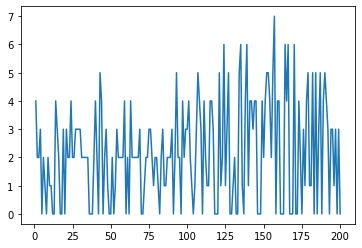

In [34]:

fig, ax = plt.subplots()
ax.plot(range(1, epochs+1), reward_sum)